In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_fixed_dt.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho_fixed_dt.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T_fixed_dt.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho.txt").reshape((-1,nnt), order = 'F')
moving_mesh = np.loadtxt("../DATA/Fsi_Results/results_mesh.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1.2

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = ROM(rom="pod")
pod.decompose(X, alg="svd",)

In [5]:
rank = 4
rec_X = pod.approximate(rank)

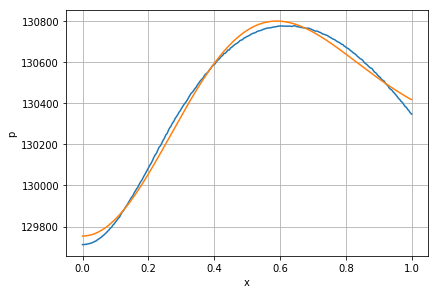

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

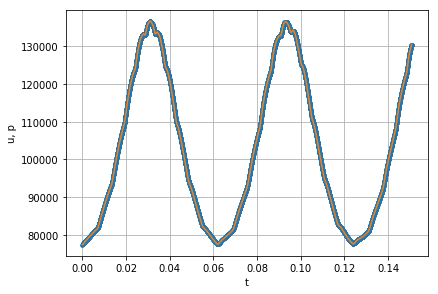

In [7]:
plt.plot(t, X[-1, :], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**Interpolate to fixed time intervals**

In [8]:
# Choose number of equally spaced timesteps 
ntt = 200
dt = t[-1] / ntt


# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T

In [15]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = .5

# Training data
XY_DATA = np.concatenate((target_fl_m_mesh[:, :int(
    ntt * Coeff)], target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

XY_DATA_2 = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
X2 = XY_DATA_2[:, :-1]
Y2 = XY_DATA_2[:, 1::]

**DMD reduction on velocity**

In [16]:
rank = 0
dmd = ROM("dmd")
dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")

In [18]:
rank = 0
dmd2 = ROM("dmd")
dmd2.decompose(X2, Y2, dt = dt, rank = rank, sorting="abs")

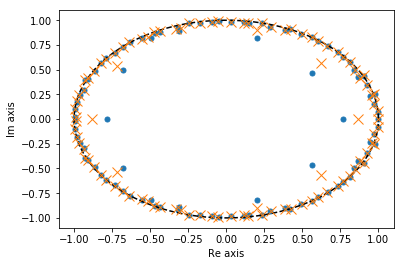

In [19]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 10);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.plot(np.real(dmd2.lambd), np.imag(dmd2.lambd), 'x', markersize = 10);

## Reconstructing X

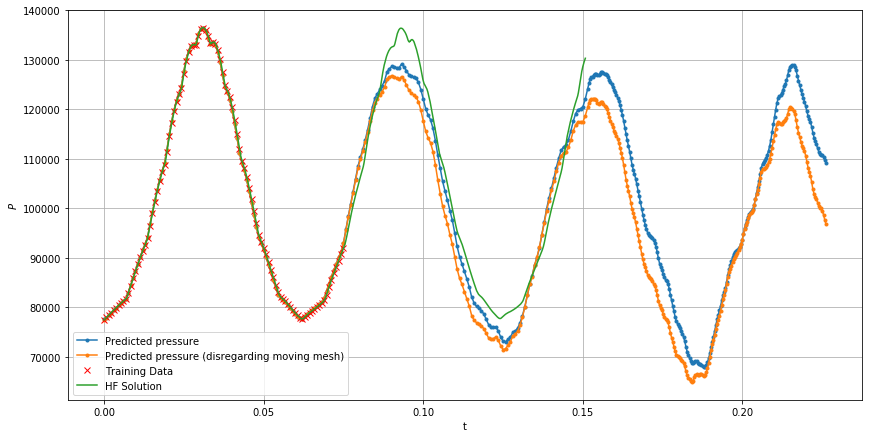

In [24]:
fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, np.linspace(target_t[-1] + dt, 1.5 * target_t[-1], int(ntt))))
predicted_X = np.real(dmd.dmd_predict(prediction_t, t[0]))
predicted_X2 = np.real(dmd2.dmd_predict(prediction_t, t[0]))

plt.plot(prediction_t, predicted_X[2 * nx-1, :], '.-', label = "Predicted pressure")
plt.plot(prediction_t, predicted_X2[nx-1, :], '.-', label = "Predicted pressure (disregarding moving mesh)")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-1, :int(ntt * Coeff)], 'xr', label = "Training Data");


plt.plot(t, fl_pressure[-1, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");

## Errors